**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500 #400
h1_dim = 250
z_dim = 2 #20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500, h1_dim=250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h1_dim)
        self.fc3 = nn.Linear(h1_dim, z_dim)
        self.fc4 = nn.Linear(h1_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, h_dim)
        self.fc7 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return torch.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 34715.7773, KL Div: 717.3933
Epoch[1/15], Step [20/469], Reconst Loss: 27544.1621, KL Div: 61.6729
Epoch[1/15], Step [30/469], Reconst Loss: 27370.1328, KL Div: 28.7081
Epoch[1/15], Step [40/469], Reconst Loss: 26150.9648, KL Div: 70.4810
Epoch[1/15], Step [50/469], Reconst Loss: 25847.4668, KL Div: 151.1277
Epoch[1/15], Step [60/469], Reconst Loss: 25897.3555, KL Div: 261.1492
Epoch[1/15], Step [70/469], Reconst Loss: 25187.7383, KL Div: 250.3098
Epoch[1/15], Step [80/469], Reconst Loss: 24017.1191, KL Div: 292.5775
Epoch[1/15], Step [90/469], Reconst Loss: 23942.4863, KL Div: 316.9510
Epoch[1/15], Step [100/469], Reconst Loss: 23194.3242, KL Div: 389.3167
Epoch[1/15], Step [110/469], Reconst Loss: 23788.7285, KL Div: 410.0400
Epoch[1/15], Step [120/469], Reconst Loss: 23353.8477, KL Div: 463.3671
Epoch[1/15], Step [130/469], Reconst Loss: 22646.5918, KL Div: 479.1967
Epoch[1/15], Step [140/469], Reconst Loss: 23184.0273, KL Div: 512.1571
Epoc

Epoch[3/15], Step [240/469], Reconst Loss: 19070.0566, KL Div: 718.0602
Epoch[3/15], Step [250/469], Reconst Loss: 18458.7188, KL Div: 735.8358
Epoch[3/15], Step [260/469], Reconst Loss: 18130.0781, KL Div: 737.3755
Epoch[3/15], Step [270/469], Reconst Loss: 19468.4922, KL Div: 712.3307
Epoch[3/15], Step [280/469], Reconst Loss: 18103.1016, KL Div: 721.9435
Epoch[3/15], Step [290/469], Reconst Loss: 19707.8281, KL Div: 757.6812
Epoch[3/15], Step [300/469], Reconst Loss: 18393.2051, KL Div: 730.7008
Epoch[3/15], Step [310/469], Reconst Loss: 19017.7227, KL Div: 699.9622
Epoch[3/15], Step [320/469], Reconst Loss: 19806.0215, KL Div: 761.9419
Epoch[3/15], Step [330/469], Reconst Loss: 18997.0312, KL Div: 756.4943
Epoch[3/15], Step [340/469], Reconst Loss: 19854.0977, KL Div: 748.3595
Epoch[3/15], Step [350/469], Reconst Loss: 19109.6992, KL Div: 721.0784
Epoch[3/15], Step [360/469], Reconst Loss: 19571.5527, KL Div: 781.8394
Epoch[3/15], Step [370/469], Reconst Loss: 18405.0938, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 18035.1934, KL Div: 776.9113
Epoch[6/15], Step [20/469], Reconst Loss: 17267.6484, KL Div: 804.8519
Epoch[6/15], Step [30/469], Reconst Loss: 18027.3066, KL Div: 809.9392
Epoch[6/15], Step [40/469], Reconst Loss: 17641.8105, KL Div: 786.0184
Epoch[6/15], Step [50/469], Reconst Loss: 18001.7383, KL Div: 759.1873
Epoch[6/15], Step [60/469], Reconst Loss: 18431.5547, KL Div: 766.7983
Epoch[6/15], Step [70/469], Reconst Loss: 17347.7773, KL Div: 804.5787
Epoch[6/15], Step [80/469], Reconst Loss: 18878.7344, KL Div: 806.4841
Epoch[6/15], Step [90/469], Reconst Loss: 17518.5137, KL Div: 778.7220
Epoch[6/15], Step [100/469], Reconst Loss: 18113.9805, KL Div: 793.5217
Epoch[6/15], Step [110/469], Reconst Loss: 17652.7617, KL Div: 771.8457
Epoch[6/15], Step [120/469], Reconst Loss: 18784.3184, KL Div: 750.5190
Epoch[6/15], Step [130/469], Reconst Loss: 17529.3398, KL Div: 765.6328
Epoch[6/15], Step [140/469], Reconst Loss: 18291.9766, KL Div: 780.7166
E

Epoch[8/15], Step [240/469], Reconst Loss: 17214.4453, KL Div: 812.5679
Epoch[8/15], Step [250/469], Reconst Loss: 17662.4336, KL Div: 835.3937
Epoch[8/15], Step [260/469], Reconst Loss: 17749.9727, KL Div: 809.6346
Epoch[8/15], Step [270/469], Reconst Loss: 17131.7383, KL Div: 803.5757
Epoch[8/15], Step [280/469], Reconst Loss: 17083.8438, KL Div: 810.1848
Epoch[8/15], Step [290/469], Reconst Loss: 17238.3242, KL Div: 831.2366
Epoch[8/15], Step [300/469], Reconst Loss: 18202.3125, KL Div: 800.0198
Epoch[8/15], Step [310/469], Reconst Loss: 17235.2559, KL Div: 775.6947
Epoch[8/15], Step [320/469], Reconst Loss: 18042.8066, KL Div: 779.9188
Epoch[8/15], Step [330/469], Reconst Loss: 18597.0156, KL Div: 823.9117
Epoch[8/15], Step [340/469], Reconst Loss: 17760.7578, KL Div: 827.0743
Epoch[8/15], Step [350/469], Reconst Loss: 17754.9062, KL Div: 752.7491
Epoch[8/15], Step [360/469], Reconst Loss: 18736.7969, KL Div: 821.1281
Epoch[8/15], Step [370/469], Reconst Loss: 17667.8730, KL Div: 8

Epoch[10/15], Step [460/469], Reconst Loss: 18156.4316, KL Div: 821.5533
Epoch[11/15], Step [10/469], Reconst Loss: 17167.9961, KL Div: 845.5079
Epoch[11/15], Step [20/469], Reconst Loss: 16540.4121, KL Div: 848.3571
Epoch[11/15], Step [30/469], Reconst Loss: 18102.7012, KL Div: 861.8835
Epoch[11/15], Step [40/469], Reconst Loss: 17152.6719, KL Div: 832.2032
Epoch[11/15], Step [50/469], Reconst Loss: 17293.2266, KL Div: 832.4493
Epoch[11/15], Step [60/469], Reconst Loss: 17276.1230, KL Div: 822.8798
Epoch[11/15], Step [70/469], Reconst Loss: 18397.7910, KL Div: 781.0696
Epoch[11/15], Step [80/469], Reconst Loss: 17962.8477, KL Div: 791.8954
Epoch[11/15], Step [90/469], Reconst Loss: 17829.2500, KL Div: 819.6792
Epoch[11/15], Step [100/469], Reconst Loss: 16630.0547, KL Div: 825.3177
Epoch[11/15], Step [110/469], Reconst Loss: 18029.8750, KL Div: 835.7793
Epoch[11/15], Step [120/469], Reconst Loss: 16805.1328, KL Div: 803.7872
Epoch[11/15], Step [130/469], Reconst Loss: 17839.9414, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 16980.1895, KL Div: 830.0214
Epoch[13/15], Step [220/469], Reconst Loss: 16880.2090, KL Div: 840.0113
Epoch[13/15], Step [230/469], Reconst Loss: 15747.8604, KL Div: 822.5775
Epoch[13/15], Step [240/469], Reconst Loss: 16874.0312, KL Div: 860.7906
Epoch[13/15], Step [250/469], Reconst Loss: 18383.8320, KL Div: 848.9656
Epoch[13/15], Step [260/469], Reconst Loss: 17009.4062, KL Div: 826.1389
Epoch[13/15], Step [270/469], Reconst Loss: 17770.6445, KL Div: 824.8194
Epoch[13/15], Step [280/469], Reconst Loss: 17601.7695, KL Div: 854.3988
Epoch[13/15], Step [290/469], Reconst Loss: 17582.6133, KL Div: 818.7653
Epoch[13/15], Step [300/469], Reconst Loss: 16523.0469, KL Div: 834.0500
Epoch[13/15], Step [310/469], Reconst Loss: 17991.3535, KL Div: 831.5938
Epoch[13/15], Step [320/469], Reconst Loss: 17169.1230, KL Div: 805.5544
Epoch[13/15], Step [330/469], Reconst Loss: 17653.0586, KL Div: 821.9726
Epoch[13/15], Step [340/469], Reconst Loss: 19390.9

Epoch[15/15], Step [420/469], Reconst Loss: 17568.8555, KL Div: 870.3005
Epoch[15/15], Step [430/469], Reconst Loss: 18212.9668, KL Div: 875.0872
Epoch[15/15], Step [440/469], Reconst Loss: 17182.9453, KL Div: 818.5169
Epoch[15/15], Step [450/469], Reconst Loss: 17077.5117, KL Div: 843.2460
Epoch[15/15], Step [460/469], Reconst Loss: 17356.4648, KL Div: 841.7615


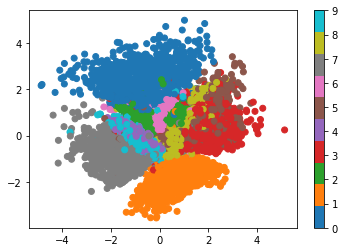

In [5]:
import matplotlib.pyplot as plt

new_data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

for i, (x, y) in enumerate(new_data_loader):
        #print(x)
        x=x.view(-1, image_size)
        #print(x)
        t = model.reparameterize(model.encode(x.to(device))[0], model.encode(x.to(device))[1])
        t = t.to(device).detach().numpy()
        plt.scatter(t[:, 0], t[:, 1], c=y, cmap='tab10')
        if i > batch_size:
            plt.colorbar()
            break

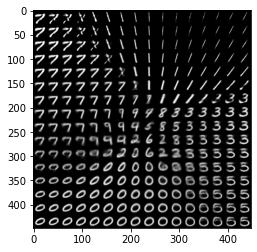

In [7]:
import numpy as np
values = np.arange(-4, 4, .5)
xx, yy = np.meshgrid(values, values)
point = np.zeros((1, 2))
# Matrix that will contain the grid of images
container = np.zeros((28 * len(values), 28 * len(values))) #392*392, 392 = 28*14



test_data_loader = torch.utils.data.DataLoader(dataset=dataset,
shuffle=True)

for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        point[0, :] = [xx[row, col], yy[row, col]]
        #print(type(input_holder))
        #torch.from_numpy(input_holder[0, :])
        #print(type(input_holder[0, :]))
        model.decode(torch.from_numpy(point[0, :]).float())
        #(artificial_image,_) = next(iter(test_data_loader))
        new_image = model.decode(torch.from_numpy(point[0, :]).float())
        new_image = new_image.detach().numpy()
        #artificial_image = artificial_image.squeeze(dim=0)
        container[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = np.reshape(new_image, (28, 28))
plt.imshow(container, cmap='gray')